In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import glob
import pickle

In [2]:
#Camera calibration, this need to run before undistort an image

images = glob.glob('camera_cal/calibration*.jpg')

objpoints = [] #3D in real space
imgpoints = [] #2D in image

objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

(720, 1280, 3)


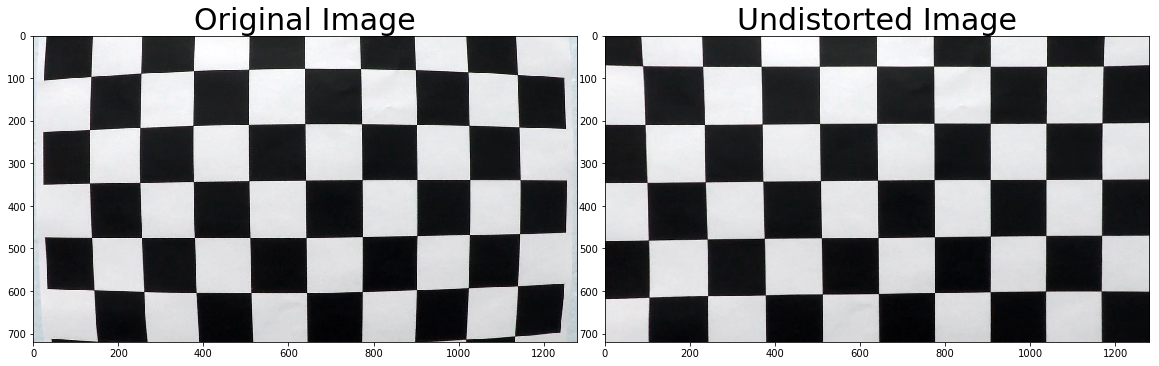

In [3]:
#undistort image

img = cv2.imread('camera_cal/calibration1.jpg')

print(img.shape)

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints,gray.shape[::-1],None,None) 
undist = cv2.undistort(img, mtx, dist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=30)

plt.show()

In [4]:
#save calibration data
calibration_data = {}
calibration_data["mtx"] = mtx
calibration_data["dist"] = dist
pickle.dump( calibration_data, open( "calibration.p", "wb" ) )

In [5]:
def apply_undistortion(img):
    undist = cv2.undistort(img, mtx, dist)
    return undist

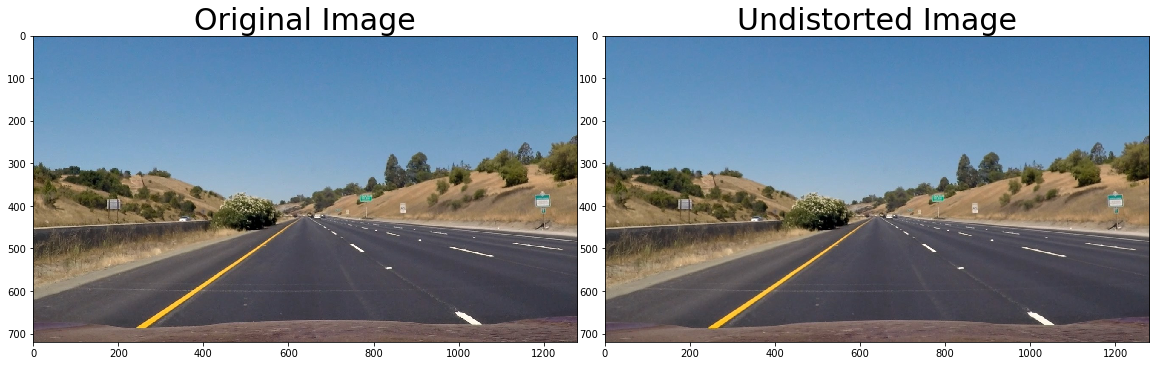

In [57]:
#load image of the road
img = cv2.imread('test_images/straight_lines1.jpg')
#img = cv2.imread('test_images/test4.jpg')

#convert to RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#undistort the image
undist = cv2.undistort(img, mtx, dist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=30)
plt.show()

In [58]:
#DEFINE SRC_POINTS
# choose src points by mouse click
# in order top left-top right-bottom right- bottom left
# to close the window and save selected points press 'x'

ix,iy = -1,-1
src_points = []
# mouse callback function
def get_coords(event,x,y,flags,param):
    global ix,iy
    if event == cv2.EVENT_LBUTTONDBLCLK:
        ix,iy = x,y
        selected_point = [ix,iy]
        src_points.append(selected_point)
        
img = img
cv2.namedWindow('image')
cv2.setMouseCallback('image',get_coords)

open = True
while(open):
    cv2.imshow('image',img)
    k = cv2.waitKey(20) & 0xFF
    if k == 27:
        break
    elif k == ord('x'):
        cv2.destroyAllWindows()
        open = False
        
if len(src_points)==4:
    print(src_points)
else:
    print("You did not select 4 Points")

[[554, 460], [720, 459], [1086, 671], [250, 668]]


In [59]:
#CALCULATE DST_POINTS
src = np.asarray(src_points, np.float32)
h,w = img.shape[:2]
dst = np.array([[0, 0],[w - 1, 0],[w - 1, h - 1],[0, h - 1]], dtype = "float32")

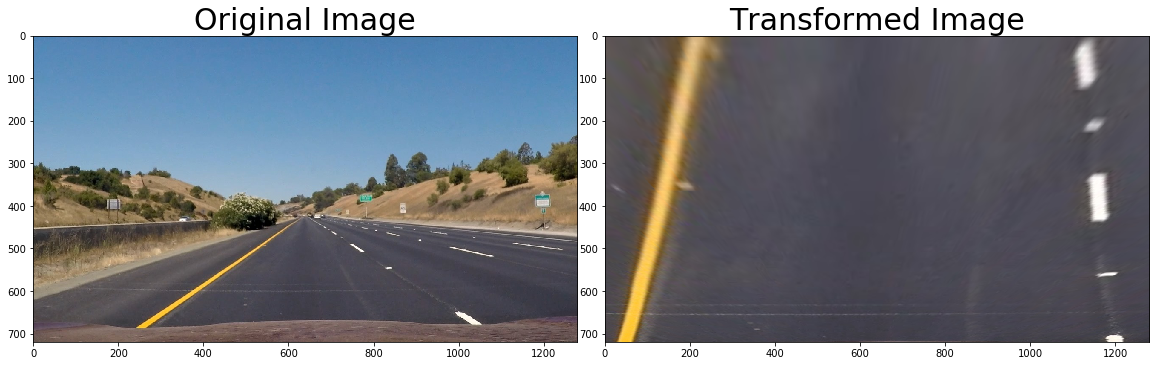

In [60]:
#APPLY PERSPECTIVE TRANSFORMATION

M = cv2.getPerspectiveTransform(src,dst)
warped = cv2.warpPerspective(img, M, (w,h), flags=cv2.INTER_LINEAR)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(warped)
ax2.set_title('Transformed Image', fontsize=30)
plt.show()

In [61]:
def perspective_transform(img):
    h,w = img.shape[:2]
    M = cv2.getPerspectiveTransform(src,dst)
    warped_image = cv2.warpPerspective(img, M, (w,h), flags=cv2.INTER_LINEAR)
    return warped_image

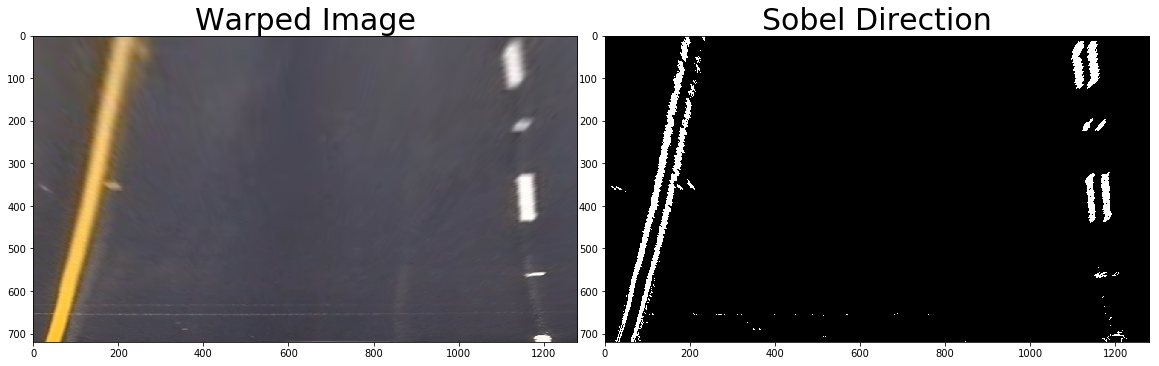

In [62]:
#DIRECTION GRADIENT
gray = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)

#absolute value
abs_sobelx = np.absolute(sobelx)

#convert to 8bit
scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

thresh_min = 20
thresh_max = 100
sxbinary = np.zeros_like(scaled_sobel)
sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(warped)
ax1.set_title('Warped Image', fontsize=30)
ax2.imshow(sxbinary, cmap='gray')
ax2.set_title('Sobel Direction', fontsize=30)

plt.show()

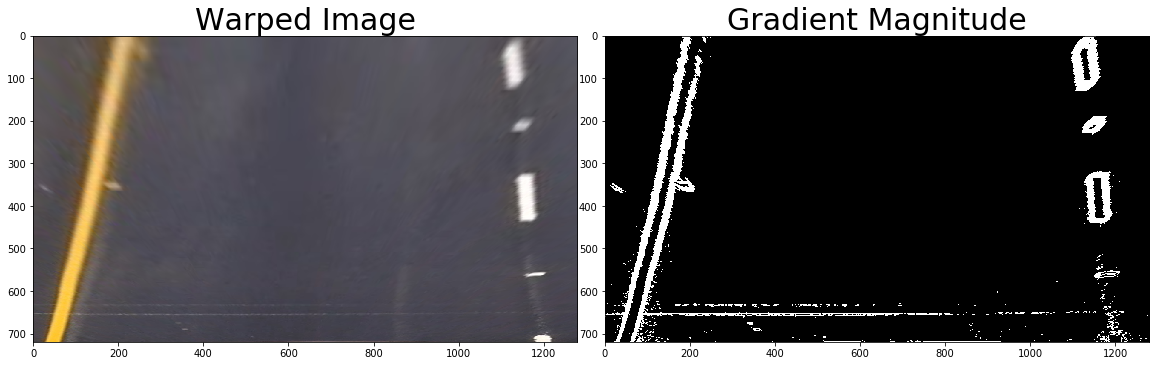

In [63]:
sobel_kernel=3
mag_thresh=(10, 100)

gray = cv2.cvtColor(warped, cv2.COLOR_RGB2GRAY)

sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

gradmag = np.sqrt(sobelx**2 + sobely**2)

scale_factor = np.max(gradmag)/255 
gradmag = (gradmag/scale_factor).astype(np.uint8) 

binary_output_mag = np.zeros_like(gradmag)
binary_output_mag[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(warped)
ax1.set_title('Warped Image', fontsize=30)
ax2.imshow(binary_output_mag, cmap='gray')
ax2.set_title('Gradient Magnitude', fontsize=30)

plt.show()


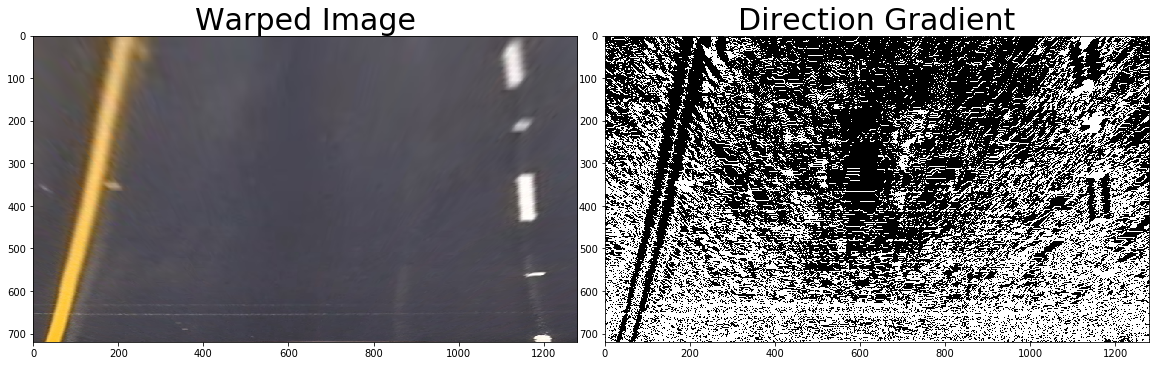

In [64]:
#Direction Gradient

sobel_kernel=3
thresh=(0.7, 1.8)

gray = cv2.cvtColor(warped, cv2.COLOR_RGB2GRAY)

sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
binary_output =  np.zeros_like(absgraddir)
binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(warped)
ax1.set_title('Warped Image', fontsize=30)
ax2.imshow(binary_output, cmap='gray')
ax2.set_title('Direction Gradient', fontsize=30)

plt.show()

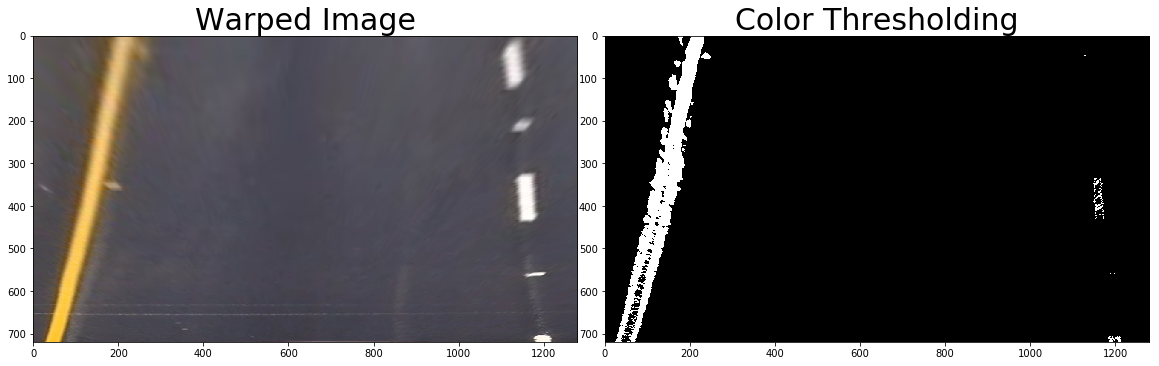

In [65]:
#COLOR THRESHOLD

gray = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
sx_binary = np.zeros_like(gray)
#define threshold for gray mask
thresh = (20, 100)
sx_binary[(gray > thresh[0]) & (gray <= thresh[1])] = 1

#HLS
hls = cv2.cvtColor(warped,cv2.COLOR_BGR2HLS)
h = hls[:,:,0]
l = hls[:,:,1]
s = hls[:,:,2]

#define threshold for binary masks
thresh = (100, 250)  #changeable

h_binary = np.zeros_like(h)
h_binary[(h > thresh[0]) & (h <= thresh[1])] = 1
l_binary = np.zeros_like(l)
l_binary[(l > thresh[0]) & (l <= thresh[1])] = 1
s_binary = np.zeros_like(s)
s_binary[(s > thresh[0]) & (s <= thresh[1])] = 1

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(warped)
ax1.set_title('Warped Image', fontsize=30)
ax2.imshow(s_binary, cmap='gray')
ax2.set_title('Color Thresholding', fontsize=30)
plt.show()

In [66]:
#Sobel Direction
def grad(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)

    #absolute value
    abs_sobelx = np.absolute(sobelx)

    #convert to 8bit
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    return sxbinary

In [67]:
#Gradient Magnitude
def grad_mag(warped):
    
    sobel_kernel=3
    mag_thresh=(25, 100)

    gray = cv2.cvtColor(warped, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output_mag = np.zeros_like(gradmag)
    binary_output_mag[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    
    return(binary_output_mag)

In [68]:
#Color Thresholding
def color_thresh(img):
    gray = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
    sx_binary = np.zeros_like(gray)
    #define threshold for gray mask
    thresh = (20, 100)
    sx_binary[(gray > thresh[0]) & (gray <= thresh[1])] = 1

    #HLS
    hls = cv2.cvtColor(warped,cv2.COLOR_BGR2HLS)
    h = hls[:,:,0]
    l = hls[:,:,1]
    s = hls[:,:,2]

    #define threshold for binary masks
    thresh = (120, 250)  #changeable

    h_binary = np.zeros_like(h)
    h_binary[(h > thresh[0]) & (h <= thresh[1])] = 1
    l_binary = np.zeros_like(l)
    l_binary[(l > thresh[0]) & (l <= thresh[1])] = 1
    s_binary = np.zeros_like(s)
    s_binary[(s > thresh[0]) & (s <= thresh[1])] = 1
    
    return s_binary


In [69]:
#Combination of Sobel Direction + Colorthresholding
def apply_grad_color_thresh(img):
    
    sxbinary = grad(img)
    s_binary = color_thresh(img)
       
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return combined_binary

In [70]:
#Combination of Gradient Magnitude + Colorthresholding
def apply_gradmag_color_thresh(img):
    
    s_binary = color_thresh(img)
    binary_output_mag = grad_mag(img)

    color_binary = np.dstack(( np.zeros_like(binary_output_mag ), binary_output_mag , s_binary)) * 255
    combined_binary = np.zeros_like(binary_output_mag )
    combined_binary[(s_binary == 1) | (binary_output_mag  == 1)] = 1
    
    return combined_binary

In [71]:
# IMAGE PROCESSING PIPELINE RETURN VALUE IS binary_warped

def preprocessing(img):
    undistorted_image = apply_undistortion(img)
    warped_image = perspective_transform(undistorted_image)
    binary_warped = apply_gradmag_color_thresh(warped_image)
    
    return binary_warped

(720, 1280)


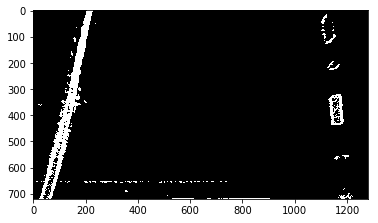

In [72]:
binary_warped = preprocessing(img)
plt.imshow(binary_warped, cmap='gray')
print(binary_warped.shape)
plt.show()

In [73]:
def fit_windows(binary_warped):
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

    # Choose the number of sliding windows
    nwindows = 8
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit

In [74]:
#left_fit, right_fit, out_img = fit_windows(binary_warped)


#ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
#left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
#right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

#plt.plot(left_fitx, ploty, color='yellow')
#plt.plot(right_fitx, ploty, color='yellow')
#plt.xlim(0, 1280)
#plt.ylim(720, 0)

#plt.imshow(out_img)
#plt.show()

In [75]:
def line_fit(binary_warped, left_fit_prev, right_fit_prev):
    
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + 
    left_fit_prev[2] - margin)) & (nonzerox < (left_fit_prev[0]*(nonzeroy**2) + 
    left_fit_prev[1]*nonzeroy + left_fit_prev[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + 
    right_fit_prev[2] - margin)) & (nonzerox < (right_fit_prev[0]*(nonzeroy**2) + 
    right_fit_prev[1]*nonzeroy + right_fit_prev[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    
    return left_fit, right_fit


In [76]:
def draw_on_img(img, binary_warped, left_fit, right_fit, Minv):

    temp_binary = np.zeros_like(binary_warped).astype(np.uint8)
    temp_color = np.dstack((temp_binary, temp_binary, temp_binary))

    h,w = temp_binary.shape
    ploty = np.linspace(0, h-1, num=h)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    cv2.polylines(temp_color, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(temp_color, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)

    cv2.fillPoly(temp_color, np.int_([pts]), (0,255, 0))
    
    
    #warps back to original perspective and combine with input img
    warped = cv2.warpPerspective(temp_color, Minv, (w, h)) 
    warped_img = cv2.addWeighted(img, 1, warped, 0.6, 0)
    
    return warped_img

In [77]:
def calc_radius_dist(binary_warped,left_fit, right_fit):
    
    h,w = binary_warped.shape
    ploty = np.linspace(0, h-1, num=h)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    #The y-value where I get the curvature
    y_eval = np.max(ploty)

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    curverad = (left_curverad + right_curverad)/2  
       
    #Calculate the central distance from the car 
    actual_pos = binary_warped.shape[1]/2
    left_line_fit = left_fit[0]*h**2 + left_fit[1]*h + left_fit[2]
    right_line_fit = right_fit[0]*h**2 + right_fit[1]*h + right_fit[2]
    center_pos = (right_line_fit + left_line_fit) /2
    center_dist = (actual_pos - center_pos) * xm_per_pix
    
    return curverad, center_dist

In [78]:
left_fit, right_fit = fit_windows(binary_warped)
left_rad, dist = calc_radius_dist(binary_warped,left_fit, right_fit)

print(left_rad)
print(dist)

4475.390944717114
0.09261074435777142


In [79]:
#Define a Line class with a detected property
class Line():
    def __init__(self):
        #Line class has 2 properties
        self.detected = False
        self.current_fit = []

In [87]:
#Pipeline for video

leftl = Line()
rightl = Line()

leftl.detected = False

def process_image(img):
        
        binary_warped = preprocessing(img)
    
        if leftl.detected is not True:
            left_fit, right_fit = fit_windows(binary_warped)
            leftl.current_fit = left_fit
            rightl.current_fit = right_fit
            leftl.detected = True

        if leftl.detected is True:
            left_fit_new, right_fit_new = line_fit(binary_warped, leftl.current_fit, rightl.current_fit)
        
        Minv = cv2.getPerspectiveTransform(dst, src)
        img_final = draw_on_img(img, binary_warped, left_fit_new, right_fit_new, Minv)
        
        rad,dist = calc_radius_dist(binary_warped,left_fit_new, right_fit_new)
        font = cv2.FONT_HERSHEY_SIMPLEX
        
        rad_text = 'Curvature:'+'{:04.2f}'.format(rad)+'m'
        dist_text = 'Lane Distance:'+'{:04.3f}'.format(dist)+'m'
        
        img_final_rad = cv2.putText(img_final,rad_text,(100,100), font, 3,(255,255,255),2,cv2.LINE_AA)
        img_final_rad = cv2.putText(img_final,dist_text,(100,190), font, 3,(255,255,255),2,cv2.LINE_AA)
        
        return img_final_rad

In [82]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

output = 'output_video/project_video_output.mp4'
clip = VideoFileClip("./project_video.mp4")
clip_processed = clip.fl_image(process_image) 
%time clip_processed.write_videofile(output, audio=False)

[MoviePy] >>>> Building video output_video/project_video_output.mp4
[MoviePy] Writing video output_video/project_video_output.mp4


100%|█████████▉| 1260/1261 [08:01<00:00,  2.32it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video/project_video_output.mp4 

Wall time: 8min 15s


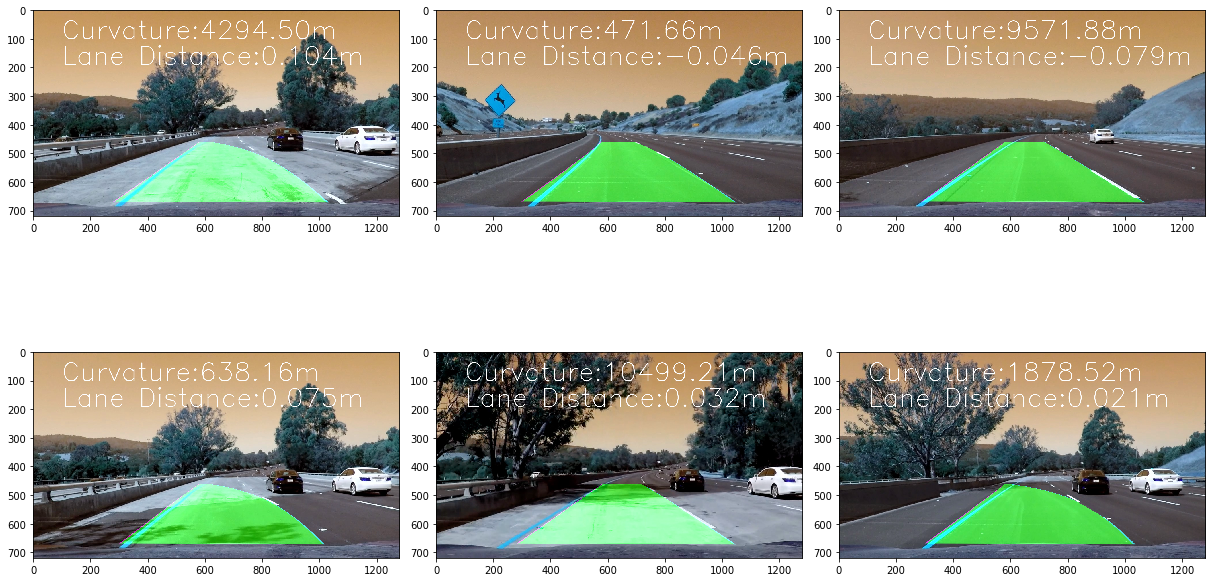

In [91]:
#Preview on test images

fig, axs = plt.subplots(2,3, figsize=(21, 12))
fig.subplots_adjust(hspace = .1, wspace=.1)
axs = axs.ravel()

images = glob.glob('test_images/test*.jpg')

for i, fname in enumerate(images):
    img = cv2.imread(fname)
    preview = process_image(img)
    axs[i].imshow(preview)
    
plt.show()
